In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import chi2

import csv
import pickle
import datetime

import autograd.numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from confint_withoutg_linear_modification import confint

import time as time

In [2]:
n = 1000
d = 1
alpha = 0.1
dist = "gamma"
df = 3
thread_num = 40
mu = 8.0#4.0(uniform)
M = 7.0#(gamma)#12.0(gaussian)#5.0(uniform)#8.0(chisq)
tau_max = 1e3#1e5#
max_iters = 50
min_iters = 15
modification = 3
opt_pts_ratio = 0.3 #subsampling ratio from design points to optimize over

In [3]:
repeat_times = 1000
coverage_rates = np.zeros(repeat_times)
entire_band_coverage_rates = np.zeros(repeat_times)

now = datetime.datetime.now()
mmddyyhhmm = ("%d_%d_%d_%d_%d" % (now.month, now.day, now.year, now.hour, now.minute))
part_of_out_fn = dist + "_n_" + str(n) + "_mod_" + str(modification) + "_uid_" + mmddyyhhmm

stuff = {}
is_save = True

run_time_ave = 0
num_nan_repeat = 0
num_acc_nan_repeat = 0

np.random.seed(1)

In [4]:
for repeat in range(repeat_times):
# Create problem data
    if (dist == "gaussian"):
        X = np.random.randn(n)
    elif (dist == "gamma"):
        X = np.random.gamma(shape=1.0, size=n)
    elif (dist == "chisq"):
        X = np.random.chisquare(df=df, size=n)
    elif(dist == "uniform"):
        X = np.random.uniform(low=-10, high=10, size=n)
    elif(dist == "mixture"):
        n_minus1 = n / 2
        n_plus1 = n - n_minus1
        X = np.concatenate([-2 + np.random.randn(n_minus1), 2 + np.random.randn(n_plus1)])
    else:
        print("ERROR: unsupported distribution")

    X = np.sort(X)

    conf_int = confint(n, X, alpha, opt_pts_ratio=opt_pts_ratio)
    t0 = time.time()
    conf_int.compute_pw_conf_ints(thread_num=thread_num, modification=modification, M=M, tau_max=tau_max, mu=mu, 
                                  max_iters=max_iters, min_iters=min_iters, want_verbose=False)
    
    t1 = time.time()
    run_time_ave += (t1 - t0) / repeat_times

    design_pts = X[conf_int.idxes_of_design_pts]

    conf_int.remove_nan()
    
    num_acc_nan_repeat += conf_int.num_nans
    
    if conf_int.num_nans != 0:
        num_nan_repeat += 1
    
    if len(conf_int.idxes_of_design_pts_to_opt) <= 1:
        continue
        
    opt_pts = X[conf_int.idxes_of_design_pts_to_opt]

    conf_int.improve_bounds_new()

    stuff[dist + str(repeat) + "_sample_pts"] = X
    stuff[dist + str(repeat) + "_design_pts"] = design_pts
    stuff[dist + str(repeat) + "_opt_design_pts"] = opt_pts
    stuff[dist + str(repeat) + "_lo"] = conf_int.lo_opt_pts
    stuff[dist + str(repeat) + "_hi"] = conf_int.hi_opt_pts
    stuff[dist + str(repeat) + "_improved_lo"] = conf_int.improved_lo_opt_pts
    
    stuff[dist + str(repeat) + "_extended_x"] = conf_int.extended_x
    stuff[dist + str(repeat) + "_extended_lo"] = conf_int.improved_lo_extended_pts
    stuff[dist + str(repeat) + "_extended_hi"] = conf_int.improved_hi_extended_pts 
    
    stuff[dist + str(repeat) + "_run_time"] = t1 - t0
    stuff[dist + str(repeat) + "_failure_num"] = conf_int.num_nans
    stuff[dist + str(repeat) + "_failure_design_pts"] = conf_int.failure_design_pts
    
    print("run_time", t1 - t0, "failure_num", conf_int.num_nans, "failure_design_pts", conf_int.failure_design_pts)
    
    if (dist == "chisq"):
        ground_truth = chi2.pdf(opt_pts, df)
    elif (dist == "gaussian"):
        ground_truth = norm.pdf(opt_pts)
    elif (dist == "uniform"):
        ground_truth = 1.0 / 20.0 * np.ones(len(opt_pts))
    elif (dist == "mixture"):
        ground_truth = 0.5 * norm.pdf(opt_pts, loc=-2) + 0.5 * norm.pdf(opt_pts, loc=2)
    elif (dist == "gamma"):
        ground_truth = gamma.pdf(opt_pts, 1.0)
    
    count = 0
    w = []
    w_rel = []
    
    for i in range(len(opt_pts)):
        if (ground_truth[i] >= conf_int.improved_lo_opt_pts[i] 
            and ground_truth[i] <= conf_int.hi_opt_pts[i]):
            count += 1
        w.append(conf_int.hi_opt_pts[i] - conf_int.improved_lo_opt_pts[i])
        w_rel.append(w[-1] / ground_truth[i])
    coverage_rate = count * 1.0 / len(opt_pts)
    coverage_rates[repeat] = coverage_rate
    if coverage_rate == 1.0:
        entire_band_coverage_rates[repeat] = 1.0
    print("===repeat:", repeat, "coverage rate:", coverage_rate, "entire band coverage rate:", entire_band_coverage_rates[repeat])
    w_ave = np.mean(np.array(w))
    w_rel_ave = np.mean(np.array(w_rel)) 
    if is_save:
        with open("coverage_rates_band_widths_%s.csv" % (part_of_out_fn), mode="a") as file_obj:
            csv_obj = csv.writer(file_obj, delimiter=",") # , quotechar='"', quoting=csv.QUOTE_MINIMAL
            csv_obj.writerow(["trial"+str(repeat), dist, coverage_rate, entire_band_coverage_rates[repeat],
                             w_ave, w,
                             w_rel_ave, w_rel,
                             t1 - t0, conf_int.num_nans, list(conf_int.failure_design_pts)])
            file_obj.close()

('num design points to optimize', 39)
setup workers
('outer loop ', 0, ' finished')
('Done. Data:', array([1.14381359e-04, 8.97929586e-03, 1.40498110e-02, 1.85027683e-02,
       2.31817641e-02, 2.81766072e-02, 3.51829446e-02, 5.12443050e-02,
       6.01350532e-02, 6.88533970e-02, 7.47365152e-02, 8.49850295e-02,
       1.03965269e-01, 1.14362388e-01, 1.27216574e-01, 1.34915326e-01,
       1.45117288e-01, 1.51272920e-01, 1.56122419e-01, 1.61868316e-01,
       1.74155371e-01, 1.89153451e-01, 1.94251275e-01, 2.04727176e-01,
       2.12791988e-01, 2.21357508e-01, 2.32721350e-01, 2.44133824e-01,
       2.51091918e-01, 2.60332865e-01, 2.74236549e-01, 2.87482999e-01,
       2.97152508e-01, 3.06929430e-01, 3.14996076e-01, 3.34946834e-01,
       3.42910111e-01, 3.56790731e-01, 3.73534729e-01, 3.79089470e-01,
       3.89612916e-01, 4.03562281e-01, 4.20114047e-01, 4.29089492e-01,
       4.38982459e-01, 4.61083414e-01, 4.72187158e-01, 4.81433101e-01,
       5.05452542e-01, 5.14821128e-01, 5.2609296

('num design points to optimize', 38)
setup workers
('outer loop ', 0, ' finished')
('Done. Data:', array([1.11545214e-03, 6.22963111e-03, 1.51333555e-02, 2.19239884e-02,
       3.02354636e-02, 3.52479763e-02, 4.03824156e-02, 4.88276051e-02,
       6.78742106e-02, 8.47266026e-02, 9.06607252e-02, 1.00995610e-01,
       1.08496949e-01, 1.16236132e-01, 1.26445374e-01, 1.36671534e-01,
       1.43170881e-01, 1.56856512e-01, 1.61530605e-01, 1.70025775e-01,
       1.82387879e-01, 1.91549367e-01, 1.99340619e-01, 2.05986172e-01,
       2.10828507e-01, 2.14431657e-01, 2.24884884e-01, 2.33316887e-01,
       2.43378595e-01, 2.56306414e-01, 2.65158273e-01, 2.74665469e-01,
       2.87361796e-01, 2.98660332e-01, 3.10664572e-01, 3.18510058e-01,
       3.24754218e-01, 3.31882031e-01, 3.37400652e-01, 3.46337930e-01,
       3.59796239e-01, 3.66957296e-01, 3.76914751e-01, 3.82644618e-01,
       3.86911645e-01, 3.96892804e-01, 4.16910734e-01, 4.28881622e-01,
       4.44587207e-01, 4.56861537e-01, 4.7355759

('num design points to optimize', 38)
setup workers
('outer loop ', 0, ' finished')
('Done. Data:', array([1.41340196e-04, 6.97921571e-03, 1.39918297e-02, 2.18448295e-02,
       3.09606488e-02, 4.01499180e-02, 4.73520431e-02, 5.03437258e-02,
       6.08908053e-02, 7.22184546e-02, 7.98383960e-02, 9.57652971e-02,
       1.01820445e-01, 1.10191499e-01, 1.20993598e-01, 1.31947375e-01,
       1.39616361e-01, 1.45915321e-01, 1.55118116e-01, 1.63017098e-01,
       1.69900196e-01, 1.82762620e-01, 1.97091762e-01, 2.04804803e-01,
       2.11915954e-01, 2.22406338e-01, 2.26975732e-01, 2.38950725e-01,
       2.53090715e-01, 2.58803238e-01, 2.67105796e-01, 2.78376101e-01,
       2.90897551e-01, 2.97316443e-01, 3.10859555e-01, 3.28289623e-01,
       3.36252264e-01, 3.48573846e-01, 3.55750568e-01, 3.72855502e-01,
       3.85022528e-01, 4.00957407e-01, 4.09078794e-01, 4.15657148e-01,
       4.24484957e-01, 4.35118046e-01, 4.47094236e-01, 4.60463139e-01,
       4.67423131e-01, 4.84676947e-01, 5.0690667

In [5]:
print("number of total nans", num_acc_nan_repeat)
print("number of repetitions containing nans", num_nan_repeat)
print("ave run time", run_time_ave)
print(sum(entire_band_coverage_rates), len(entire_band_coverage_rates))

('number of total nans', 0)
('number of repetitions containing nans', 0)
('ave run time', 0.8607500538825988)


In [ ]:
if is_save:
    pickle.dump(stuff, open("data_%s.pkl" % (part_of_out_fn), "wb"))

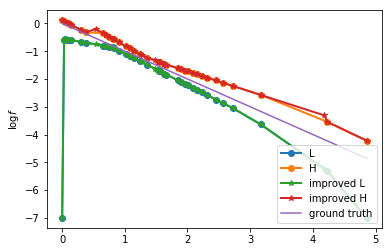

In [8]:
%matplotlib inline

if (dist == "chisq"):
    ground_truth = chi2.pdf(opt_pts, df)
elif (dist == "gaussian"):
    ground_truth = norm.pdf(opt_pts)
elif (dist == "uniform"):
    ground_truth = 1.0 / 20.0 * np.ones(len(opt_pts))
elif (dist == "mixture"):
    ground_truth = 0.5 * norm.pdf(opt_pts, loc=-2) + 0.5 * norm.pdf(opt_pts, loc=2)
elif (dist == "gamma"):
    ground_truth = gamma.pdf(opt_pts, 1.0)

plt.figure()
plt.subplot(111)
plt.plot(opt_pts, np.log(conf_int.lo_opt_pts), '-o', linewidth=2.0, label="L")
plt.plot(opt_pts, np.log(conf_int.hi_opt_pts), '-o', linewidth=2.0, label="H")
plt.plot(conf_int.extended_x, np.log(conf_int.improved_lo_extended_pts), '-*', linewidth=2.0, label="improved L")
plt.plot(conf_int.extended_x, np.log(conf_int.improved_hi_extended_pts), '-*', linewidth=2.0, label="improved H")
plt.plot(opt_pts, np.log(ground_truth), label="ground truth")
plt.legend(loc=4)
plt.ylabel("$\log f$")